In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
# Load the data
file_path = "./data/download.grib"

dataset = xr.load_dataset(file_path)
dataset

Ignoring index file './data/download.grib.5b7b6.idx' older than GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/home/h05/llee/.conda/envs/data_readiness_era5/lib/python3.12/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/h05/llee/.conda/envs/data_readiness_era5/lib/python3.12/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1695686400, 1695690000, 1695693600, 1695697200, 1695700800,
       1695704400, 1695708000, 1695711600, 1695715200, 1695718800,
       1695722400, 1695726000, 1695729600, 1695733200, 1695736800,
       1695740400, 1695744000, 1695747600, 1695751200, 1695754800,
       1695758400, 1695762000, 1695765600, 1695769200])) new_value=Variable(dimensions=('time',), data=array([16

<xarray.Dataset> Size: 498MB
Dimensions:     (time: 24, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 192B 2023-09-26 ... 2023-09-26T23:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 192B 2023-09-26 ... 2023-09-26T23:00:00
Data variables:
    u10         (time, latitude, longitude) float32 100MB -4.954 -4.954 ... 4.54
    v10         (time, latitude, longitude) float32 100MB 8.613 8.613 ... 2.526
    d2m         (time, latitude, longitude) float32 100MB 265.8 265.8 ... 220.4
    t2m         (time, latitude, longitude) float32 100MB 267.3 267.3 ... 224.3
    sp          (time, latitude, longitude) float32 100MB 1.013e+05 ... 6.821...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-25T13:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
# Define hyper parameters to later be used and logged
Config = namedtuple('Config', ['batch_size', 'resolution', 'num_epochs', 'learning_rate', 'test_size', 'output_activation'])
config = Config(8, 0.5, 100, 1e-3, 0.2, None)

In [4]:
data_vars = list(dataset.data_vars)
data_vars

['u10', 'v10', 'd2m', 't2m', 'sp']

In [5]:
%%time

dataset_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, config.resolution), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(-180, 180, config.resolution), {"units": "degrees_east"}),
    }
)

regridder = xe.Regridder(dataset, dataset_out, "conservative")

regridded_dataset = regridder(dataset, keep_attrs=True)
regridded_dataset

/home/h05/llee/.conda/envs/data_readiness_era5/lib/python3.12/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/h05/llee/.conda/envs/data_readiness_era5/lib/python3.12/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


CPU times: user 50 s, sys: 1.62 s, total: 51.6 s
Wall time: 52.3 s


<xarray.Dataset> Size: 124MB
Dimensions:     (time: 24, lat: 360, lon: 720)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 192B 2023-09-26 ... 2023-09-26T23:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 192B 2023-09-26 ... 2023-09-26T23:00:00
  * lat         (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5
  * lon         (lon) float64 6kB -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
Data variables:
    u10         (time, lat, lon) float32 25MB 0.3221 0.321 ... -3.17 -3.103
    v10         (time, lat, lon) float32 25MB 0.7954 0.7954 ... 7.974 7.99
    d2m         (time, lat, lon) float32 25MB 55.94 55.94 55.94 ... 262.5 262.5
    t2m         (time, lat, lon) float32 25MB 56.96 56.96 56.97 ... 264.8 264.8
    sp          (time, lat, lon) float32 25MB 1.711e+04 1.711e+04 ... 1.017e+05
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-25T13:39 GRIB to CDM+CF via cfgrib-0.9.1...
    regrid_method:           conservative

In [6]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract variables from dataset and stack them into a numpy array (time, lat, long, vars)
data = np.stack([regridded_dataset[var].values for var in data_vars], axis=-1)

# Reshape the data for StandardScaler (it expects 2D, so combine lat, long, and vars)
# Reshape to (time, lat*long*vars) for scaling, later we'll reshape back
n_time, n_lat, n_long, n_vars = data.shape
reshaped_data = data.reshape(n_time, -1)

# Fit and transform the data using StandardScaler
scaled_data = scaler.fit_transform(reshaped_data)

# Reshape back to original (time, lat, long, vars) shape
standardized_data = scaled_data.reshape(n_time, n_lat, n_long, n_vars)

# Split the data into training and test sets
X_train, X_test = train_test_split(standardized_data, test_size=config.test_size)

# Convert to PyTorch tensors and change dimensions to (time, vars, lat, long)
tensor_data_train = torch.Tensor(X_train).permute(0, 3, 1, 2)
tensor_data_test = torch.Tensor(X_test).permute(0, 3, 1, 2)

# Create TensorDataset
tensor_dataset_train = TensorDataset(tensor_data_train)
tensor_dataset_test = TensorDataset(tensor_data_test)

# Create DataLoaders
train_loader = DataLoader(tensor_dataset_train, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(tensor_dataset_test, batch_size=config.batch_size, shuffle=True)

In [7]:
# Define the model
class ConvAutoencoder(nn.Module):
    def __init__(self, num_vars, longitude, latitude):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(num_vars, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, num_vars, kernel_size=3, stride=2, padding=1),  
        )

        self.long = longitude
        self.lat = latitude

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        # Crop to correct dimension
        x = x[:,:,:self.lat,:self.long]
        return x

model = ConvAutoencoder(num_vars=len(data_vars), longitude=tensor_data_train.shape[-1], latitude=tensor_data_train.shape[-2])

In [8]:
# Set up Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs --port 6006

Reusing TensorBoard on port 6006 (pid 64621), started 4 days, 22:47:20 ago. (Use '!kill 64621' to kill it.)

In [9]:
%%time

# Define tensorboard writer
writer = SummaryWriter()

# Write the config hyperparameters to tensorboard
for field in config._fields:
    writer.add_text(field, str(getattr(config, field)))

# Define the loss function and the optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

num_epochs = config.num_epochs

# Training loop
for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Calculate average training loss
    train_loss /= len(train_loader)

    # Write train loss to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)

    # Evaluate on the test set
    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for data in test_loader:
            inputs = data[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Write test loss to tensorboard
    writer.add_scalar("Loss/test", test_loss, epoch)

    print(f"Epoch [{epoch}/{num_epochs-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

writer.close()
print("Training completed.")

Epoch [0/99], Train Loss: 1.0020, Test Loss: 1.0075
Epoch [1/99], Train Loss: 1.0029, Test Loss: 1.0041
Epoch [2/99], Train Loss: 1.0383, Test Loss: 0.9961
Epoch [3/99], Train Loss: 1.0553, Test Loss: 0.9791
Epoch [4/99], Train Loss: 1.0041, Test Loss: 0.9550
Epoch [5/99], Train Loss: 0.9889, Test Loss: 0.9259
Epoch [6/99], Train Loss: 0.8832, Test Loss: 0.8966
Epoch [7/99], Train Loss: 0.8824, Test Loss: 0.8663
Epoch [8/99], Train Loss: 0.9031, Test Loss: 0.8371
Epoch [9/99], Train Loss: 0.8302, Test Loss: 0.8092
Epoch [10/99], Train Loss: 0.7982, Test Loss: 0.7836
Epoch [11/99], Train Loss: 0.7533, Test Loss: 0.7603
Epoch [12/99], Train Loss: 0.7517, Test Loss: 0.7381
Epoch [13/99], Train Loss: 0.7409, Test Loss: 0.7150
Epoch [14/99], Train Loss: 0.6733, Test Loss: 0.6910
Epoch [15/99], Train Loss: 0.6457, Test Loss: 0.6680
Epoch [16/99], Train Loss: 0.6528, Test Loss: 0.6451
Epoch [17/99], Train Loss: 0.6634, Test Loss: 0.6238
Epoch [18/99], Train Loss: 0.6348, Test Loss: 0.6033
Epo

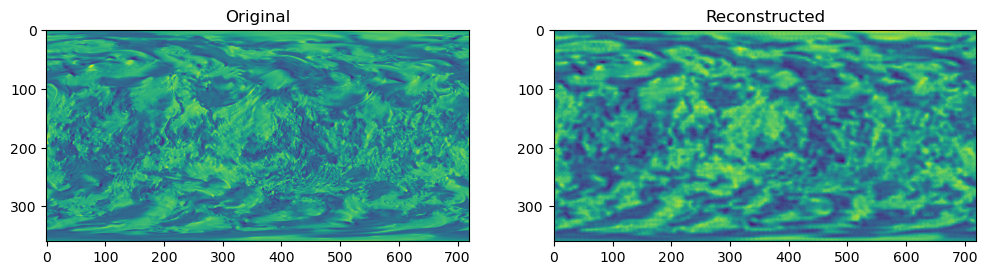

In [10]:
# Function to plot original vs reconstructed data
def plot_reconstruction(original, reconstructed, variable_index=0, time_index=0):
    original = original.detach().cpu().numpy()
    reconstructed = reconstructed.detach().cpu().numpy()

    # Select a specific time index and variable to visualize
    original_field = original[time_index, variable_index, :, :]
    reconstructed_field = reconstructed[time_index, variable_index, :, :]

    # Plot original and reconstructed side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_field, cmap='viridis')
    axes[0].set_title('Original')

    axes[1].imshow(reconstructed_field, cmap='viridis')
    axes[1].set_title('Reconstructed')

    plt.show()

# Get a batch of test data
data_iter = iter(test_loader)
test_data = next(data_iter)[0]

# Set the model in evaluation mode and turn off gradient calculations
model.eval()
with torch.no_grad():
    # Pass the test data through the model to get the reconstruction
    reconstructed_data = model(test_data)

# Visualize the original vs reconstructed data
plot_reconstruction(test_data, reconstructed_data)